In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-adult-pmr3508-2021-2/sample_submission.csv
/kaggle/input/data-adult-pmr3508-2021-2/train_data.csv
/kaggle/input/data-adult-pmr3508-2021-2/test_data.csv
/kaggle/input/data-adult-pmr3508-2021-2/Extra-file-from-UCI.txt


In [31]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn

## Objective  

Predict whether income exceeds $50K/yr based on census data using k-Nearest Neighbors Classifier. Model (number of neighbors) selection will be done based on cross validation score.
 
**What to consider about the model as a basis**

* kNN is sensitive to scaling and missing data.

* It is robust to outliers. 

* Cost is directly related to the number of features as it leads to higher dimensionality.


## Data Preparation

This section will be focused on cleaning and some feature engineering to make the data ready to work with a kNN model.

In [32]:
train_data_df = pd.read_csv('/kaggle/input/data-adult-pmr3508-2021-2/train_data.csv', na_values = "?")
test_data_df =  pd.read_csv('/kaggle/input/data-adult-pmr3508-2021-2/test_data.csv', na_values = "?")

In [33]:
train_data_df.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [34]:
test_data_df.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,25,Private,120596,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,44,United-States
1,1,64,State-gov,152537,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
2,2,31,Private,100135,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
3,3,45,Private,189123,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
4,4,64,Self-emp-inc,487751,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States


I am going to drop two colunms here that I think are less necessary, "fnlwgt" and "education". The first variable just stores the number of rows with the exact same value and "education" is a redundant category since "education.num" exists.

In [35]:
train_data_df = train_data_df.drop(["fnlwgt", "education"], axis = 1)
test_data_df = test_data_df.drop(["fnlwgt", "education"], axis = 1)

In [36]:
adult_data = pd.concat([test_data_df, train_data_df])
adult_data.describe(include='all')

,Id,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,48840.00000,48840.000000,46041,48840.000000,48840,46031,48840,48840,48840,48840.000000,48840.000000,48840.000000,47983,32560
unique,NaN,NaN,8,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,NaN,Private,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,NaN,33905,NaN,22379,6172,19716,41761,32648,NaN,NaN,NaN,43830,24719
mean,24419.50000,38.643857,NaN,10.078092,NaN,NaN,NaN,NaN,NaN,1079.067301,87.505897,40.422400,NaN,NaN
std,14099.03791,13.710652,NaN,2.570954,NaN,NaN,NaN,NaN,NaN,7452.168393,403.012415,12.391697,NaN,NaN
min,0.00000,17.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,12209.75000,28.000000,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,24419.50000,37.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,36629.25000,48.000000,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


**Handling missing data** 

In [37]:
train_data_df.isna().sum()

Id                   0
age                  0
workclass         1836
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

All columns with missing data are categorical and could be treated with imputation techniques. In this case I'll be arbitrarily substituting the missing values with the string "Missing" and then looking at the distributions in those variables as it might be interesting to group together the less frequent categories to facilitate encoding.

In [38]:
cols_missing = ['workclass', 'occupation', 'native.country']
train_data_df[cols_missing] = train_data_df[cols_missing].fillna("Missing")
test_data_df[cols_missing] = test_data_df[cols_missing].fillna("Missing")
train_data_df.isna().sum()

Id                0
age               0
workclass         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


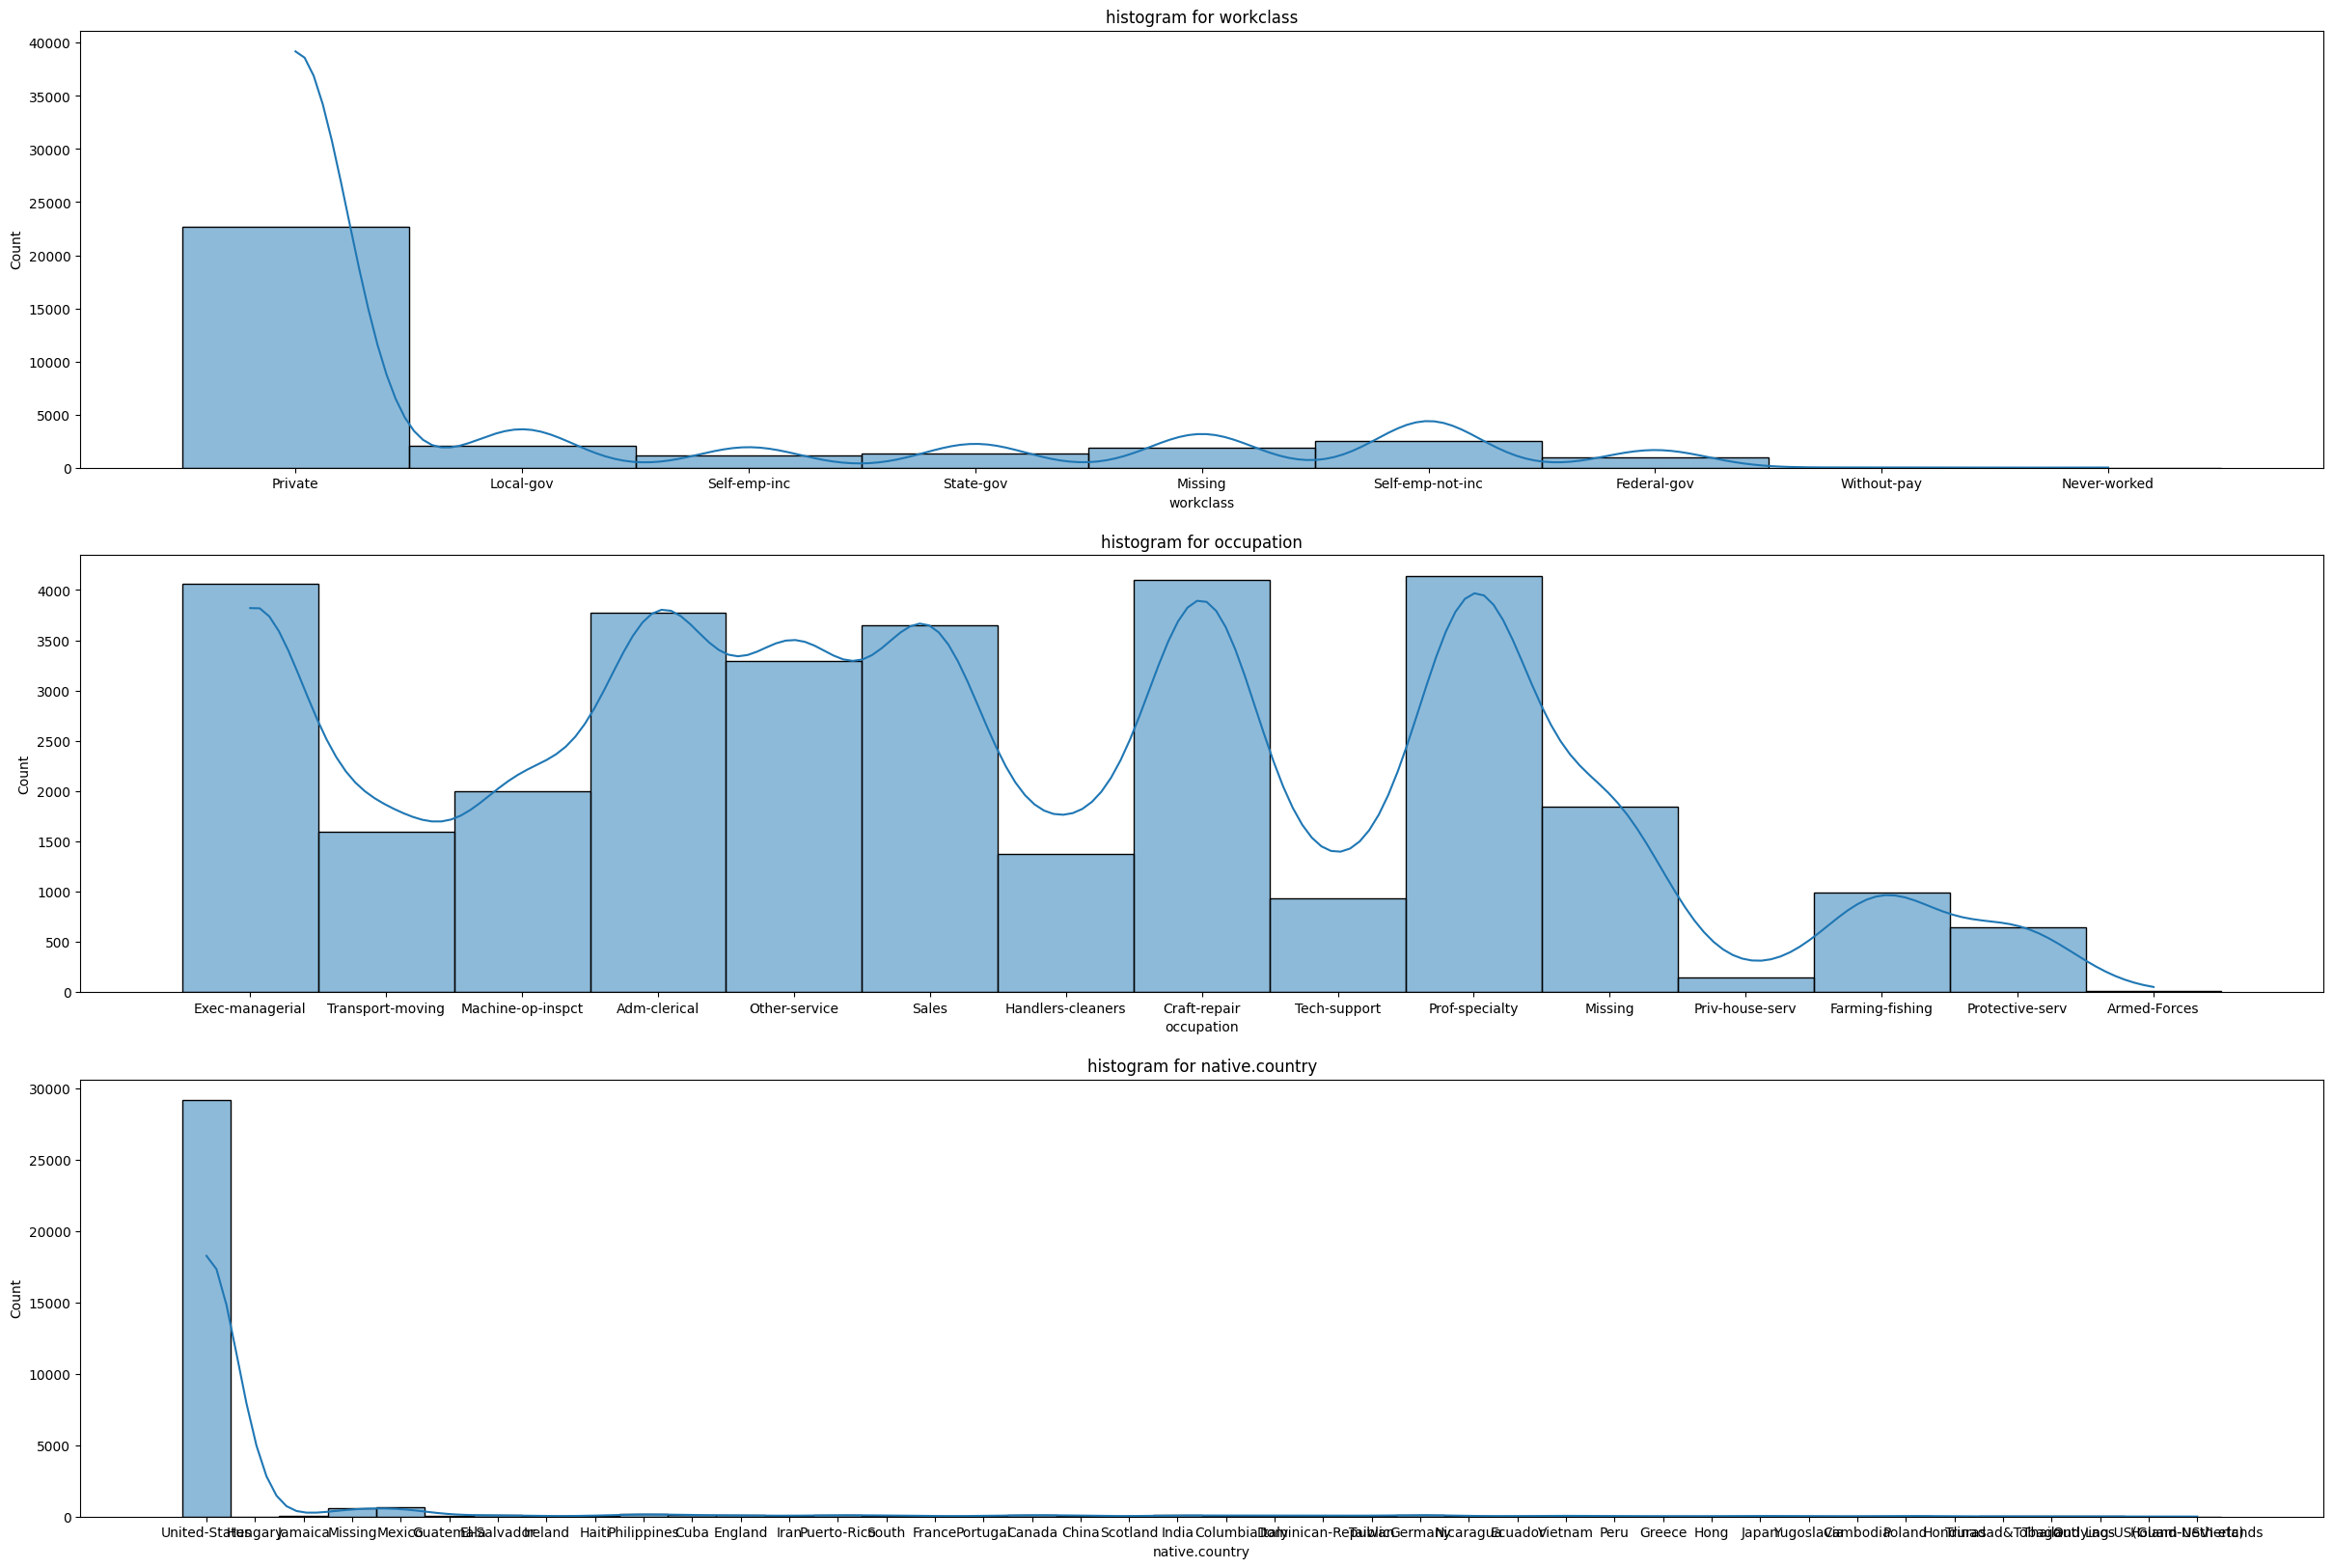

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(30, 20))   
for ax, col in zip(axes.flat, cols_missing):
    sns.histplot(train_data_df[col], ax = ax,  kde=True)
    ax.set_title(f'histogram for {col}')

Creating a "Missing" label did not disturb the probability distribution significantly in any of the variables as it is being seem in the kde (Kernel Distribution Estimate) parameter, "native.country" and "workclass" could be subdivided in two categories, however "occupation" is more uniformily distributed and the label "Missing" could probably be more accurately described as "Unemployed".

In [40]:
train_data_df['native.country'] = train_data_df['native.country'].mask(
    train_data_df['native.country'] != 'United-States', 'Outside US') #using the mode for the reference string
train_data_df['workclass'] = train_data_df['workclass'].mask(
    train_data_df['workclass'] != 'Private', 'Public-or-other')
train_data_df['occupation'] = train_data_df['occupation'].replace('Missing', 'Unemployed', regex = True)
#same idea for test data
test_data_df['native.country'] = test_data_df['native.country'].mask(
    test_data_df['native.country'] != 'United-States', 'Outside US')
test_data_df['workclass'] = test_data_df['workclass'].mask(
    test_data_df['workclass'] != 'Private', 'Public-or-other')
test_data_df['occupation'] = test_data_df['occupation'].replace('Missing', 'Unemployed', regex = True)

train_data_df.describe (include = 'all')

,Id,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,32560.000000,32560.000000,32560,32560.000000,32560,32560,32560,32560,32560,32560.000000,32560.000000,32560.000000,32560,32560
unique,NaN,NaN,2,NaN,7,15,6,5,2,NaN,NaN,NaN,2,2
top,NaN,NaN,Private,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,NaN,22696,NaN,14976,4140,13193,27815,21789,NaN,NaN,NaN,29169,24719
mean,32559.500000,38.581634,NaN,10.080590,NaN,NaN,NaN,NaN,NaN,1077.615172,87.306511,40.437469,NaN,NaN
std,9399.406719,13.640642,NaN,2.572709,NaN,NaN,NaN,NaN,NaN,7385.402999,402.966116,12.347618,NaN,NaN
min,16280.000000,17.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,24419.750000,28.000000,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,32559.500000,37.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,40699.250000,48.000000,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


**More categorical exploration and encoding**

There are three other categorical variables left, "relationship", "marital.status" and "race". "sex" is a binary variable and does not need special attention. I will explore them and then finally encode. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


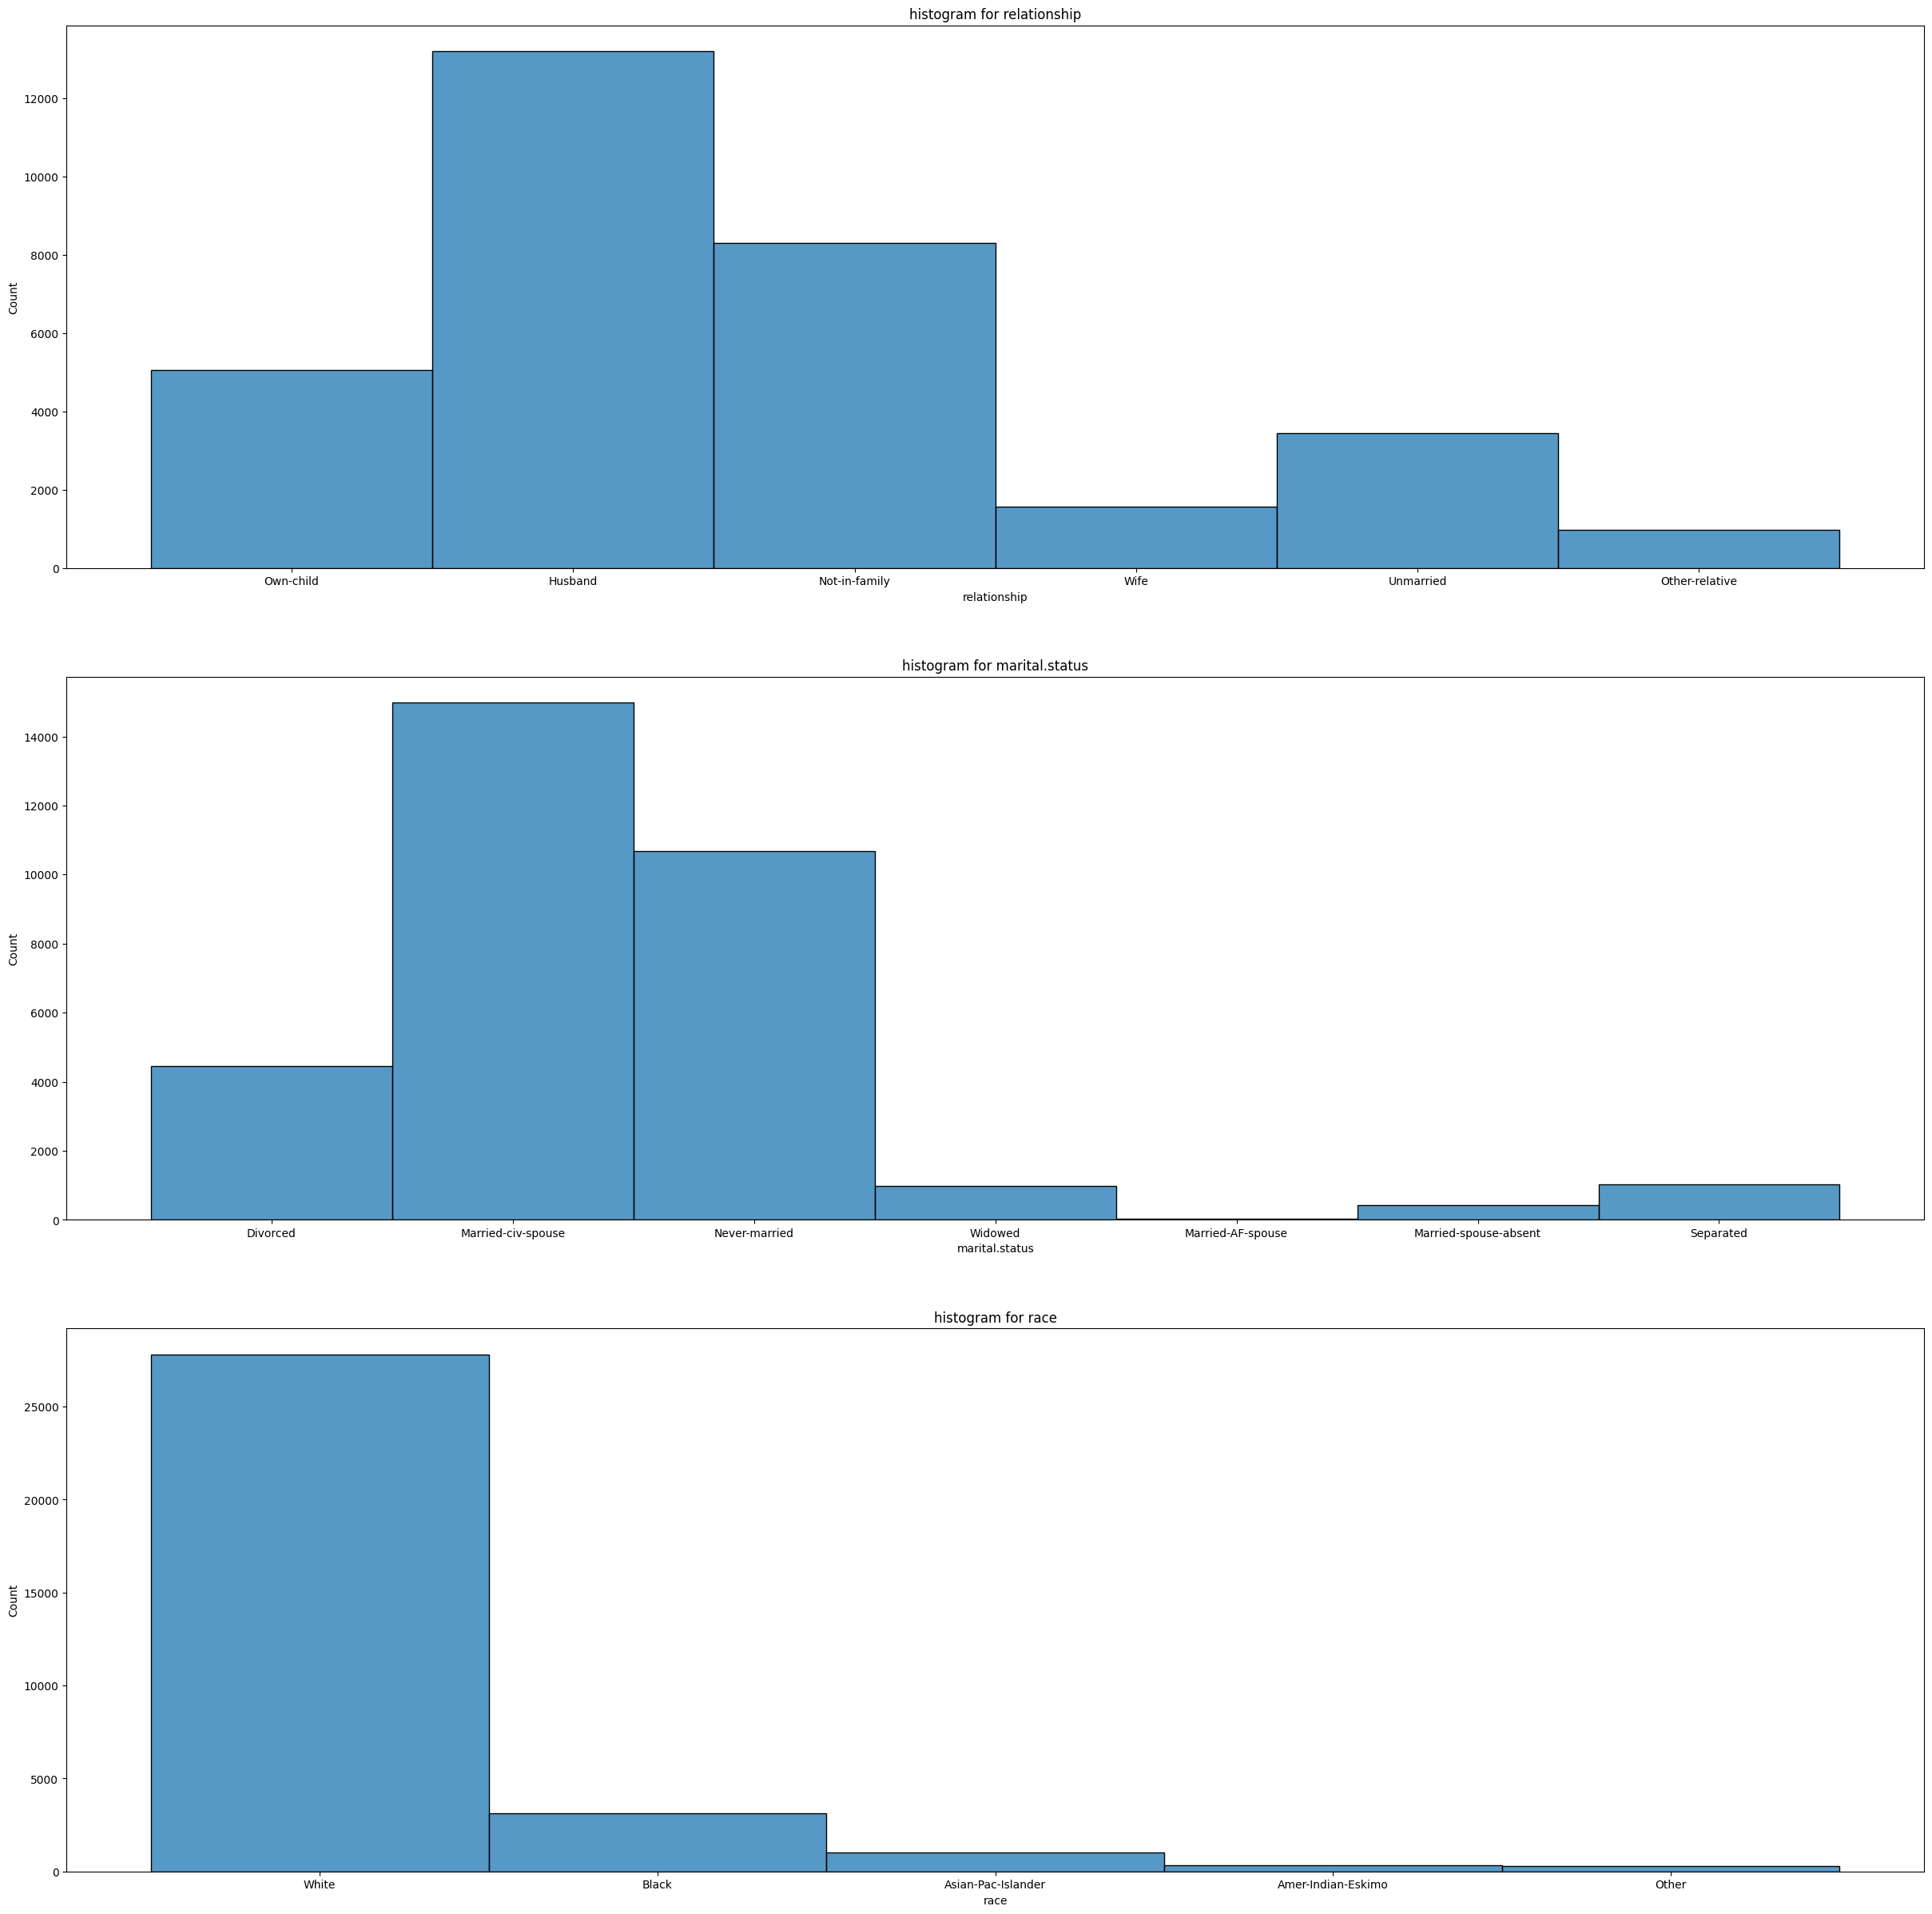

In [41]:
other_categorical = ["relationship", "marital.status", "race"]
categorical = np.concatenate ((other_categorical, cols_missing))
fig, axes = plt.subplots(3, 1, figsize=(30, 30))   
for ax, col in zip(axes.flat, other_categorical):
    sns.histplot (data = train_data_df[col], ax = ax)
    ax.set_title(f'histogram for {col}')

* "race" is a very skewed categorical feature like we have seen before, therefore its rare labels will be grouped.

* "marical.status" and "relationship" are similar features but in this model I will be using both, as I think they compliment each other at the points with interesting lifestyle informations.

In [42]:
train_data_df['race'] = train_data_df['race'].mask(
    train_data_df['race'] != 'White', 'Non-white')
test_data_df['race'] = test_data_df['race'].mask(
    test_data_df['race'] != 'White', 'Non-white')

Now, I will encode using scikit-learn.

In [43]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(
    categories="auto",
    drop="first",  # to return k-1 dummies, useful because these variables are binary
    sparse_output=False,
    handle_unknown="error",
)

OHE.set_output(transform="pandas")
OHE_columns_1 = ['race', 'sex', 'native.country', 'workclass', 'income']
OHE.fit(train_data_df[OHE_columns_1])
train_enc_1 = OHE.transform(train_data_df[OHE_columns_1])
OHE_columns_1 = ['race', 'sex', 'native.country', 'workclass']
OHE.fit(train_data_df[OHE_columns_1])
test_enc_1 = OHE.transform(test_data_df[OHE_columns_1])

#I want to cap how much the feature space expands for these variables
OHE_frequent = OneHotEncoder(
    handle_unknown="infrequent_if_exist", # could be useful in higher cardinality may not be in this case  
    max_categories=15,  
    sparse_output=False, 
)

OHE_frequent.set_output(transform="pandas")
OHE_columns_2 = ['relationship' , 'occupation', 'marital.status']
OHE_frequent.fit(train_data_df[OHE_columns_2])
train_enc_2 = OHE_frequent.transform(train_data_df[OHE_columns_2])
test_enc_2 = OHE_frequent.transform(test_data_df[OHE_columns_2])

train_enc = pd.concat([train_enc_1,train_enc_2], axis = 1)
test_enc = pd.concat([test_enc_1,test_enc_2], axis = 1)
OHE_train = pd.concat([train_data_df, train_enc], axis = 1)
OHE_test = pd.concat([test_data_df, test_enc], axis = 1)

OHE_train.head()

,Id,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,...,occupation_Transport-moving,occupation_Unemployed,occupation_infrequent_sklearn,marital.status_Divorced,marital.status_Married-AF-spouse,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,marital.status_Never-married,marital.status_Separated,marital.status_Widowed
0,16280,34,Private,10,Divorced,Exec-managerial,Own-child,White,Male,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16281,58,Public-or-other,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,16282,25,Private,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16283,24,Private,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16284,57,Public-or-other,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Numerical features**

As a last step before scaling the features, making it so that feature magnitude doesn't affect the model, I want to look at the histograms for the numerical features.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

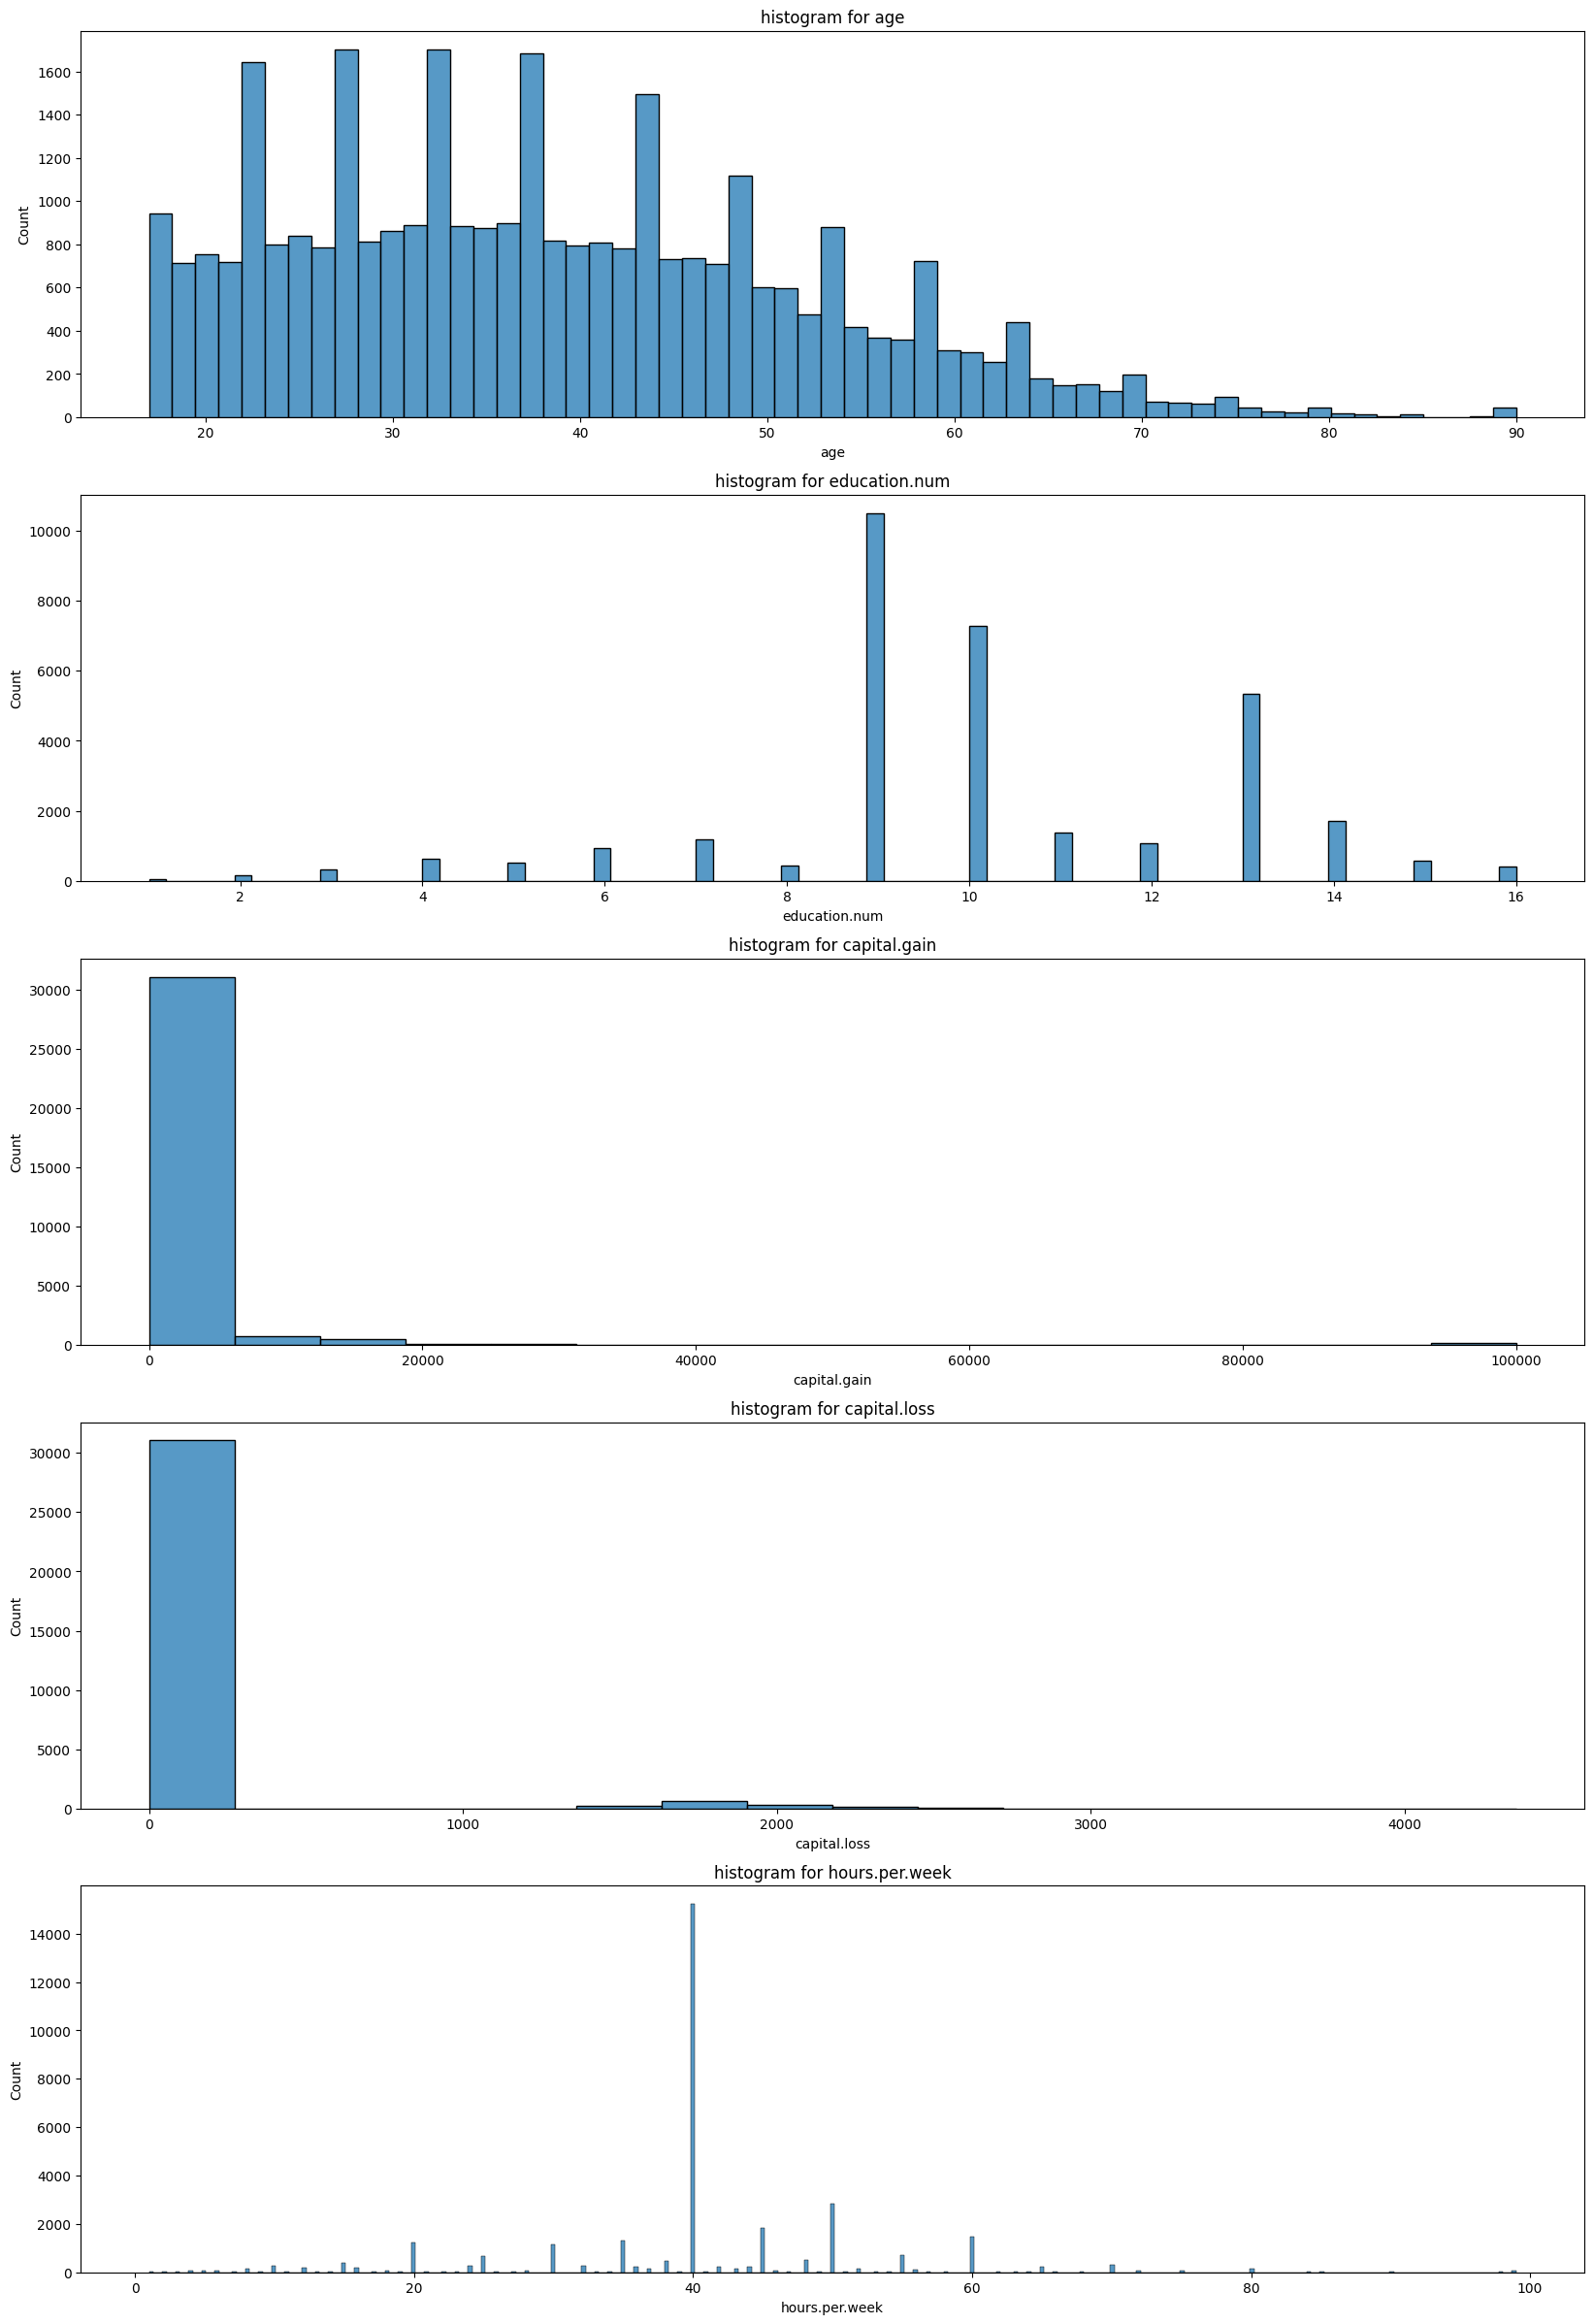

In [44]:
numerical = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]
fig, axes = plt.subplots(5, 1, figsize=(20, 30))   
for ax, col in zip(axes.flat, numerical):
    sns.histplot (data = OHE_train[col], ax = ax)
    ax.set_title(f'histogram for {col}')

I will also check the correlation matrix.

<Axes: >

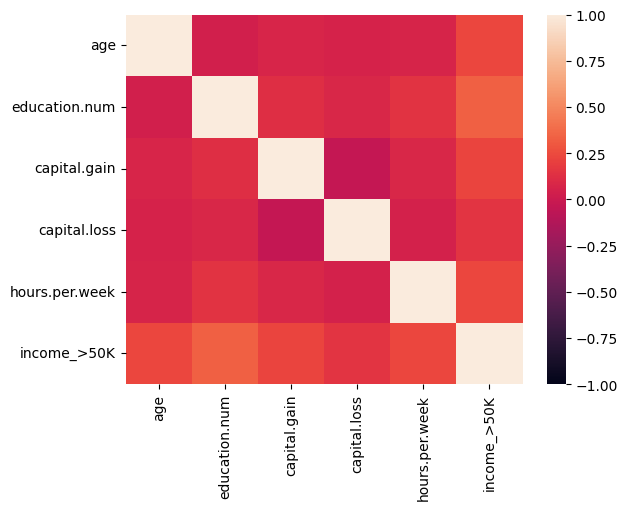

In [45]:
numerical.append('income_>50K')
sns.heatmap(OHE_train[numerical].corr(), vmin = -1, vmax = 1)

In [46]:
OHE_train['total.capital'] = OHE_train['capital.gain'] - OHE_train['capital.loss']
OHE_test['total.capital'] = OHE_test['capital.gain'] - OHE_test['capital.loss']

In [47]:
from sklearn.preprocessing import MinMaxScaler 
columns_scale = ['age', 'education.num', 'hours.per.week', 'total.capital']
scaler = MinMaxScaler().set_output(transform="pandas")
scaler.fit(OHE_train[columns_scale])

OHE_train_scaled = scaler.transform(OHE_train[columns_scale])
OHE_test_scaled = scaler.transform(OHE_test[columns_scale])
OHE_train_scaled.head()

,age,education.num,hours.per.week,total.capital
0,0.232877,0.600000,0.438776,0.041742
1,0.561644,0.333333,0.397959,0.041742
2,0.109589,0.600000,0.418367,0.041742
3,0.095890,0.600000,0.397959,0.041742
4,0.547945,0.533333,0.602041,0.091361


## Implementing the kNN classifier

Now that the data preparation steps have been fulfilled, the classifier can be fitted to training set and evaluated by the statistical parameters.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score,
recall_score, f1_score, confusion_matrix)
from sklearn.model_selection import cross_val_score

X = pd.concat([OHE_train_scaled, train_enc], axis = 1)
X = X.drop(['income_>50K'], axis = 1)
y = OHE_train.income
knn = KNeighborsClassifier(n_neighbors=30)
cross_val_score(knn, X, y, cv = 10)

array([0.83292383, 0.83507371, 0.83568796, 0.8264742 , 0.83292383,
       0.82985258, 0.83937346, 0.83261671, 0.83015971, 0.83599509])

Accuracy: 0.8296478296478297, Precision: 0.8581215744892875, Recall: 0.9291880226598328, 
F1-score: 0.8922419375728533


<Axes: title={'center': 'Confusion Matrix Heatmap'}>

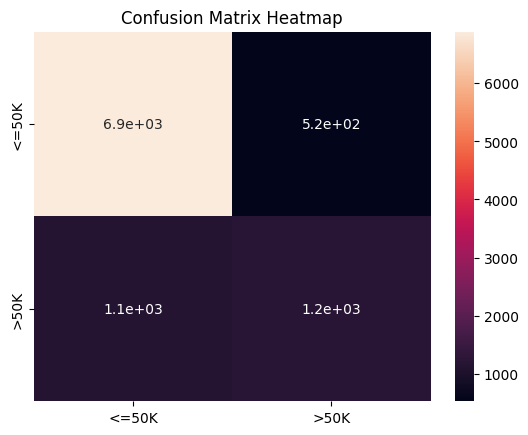

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label = '<=50K')
recall = recall_score(y_test, y_pred, pos_label = '<=50K')
f1 = f1_score(y_test, y_pred, pos_label = '<=50K')

print(
    f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, \nF1-score: {f1}"  
)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix Heatmap")
sns.heatmap(conf_matrix, annot = True, xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])

In [50]:
X_test_df = pd.concat([OHE_test_scaled, test_enc], axis = 1)
knn.fit(X, y)
y_result = knn.predict(X_test_df)

prediction_df = pd.DataFrame()
prediction_df["Id"] = OHE_test.index
prediction_df["income"] = y_result
prediction_df.head()

,Id,income
0,0,<=50K
1,1,>50K
2,2,<=50K
3,3,<=50K
4,4,>50K


In [51]:
prediction_df.to_csv('/kaggle/working/submission.csv', index=False)